# PLQE ANALYSIS

In [1]:
from analysis_functions import *
from scipy.interpolate import BSpline, splrep, splev
from cmcrameri import cm

import matplotlib
plt.rcParams['savefig.dpi'] = 200

* **Laser range**: This is the min/max value of the laser peak. For the lasers we have,this will be:
       * **405nm**: 395 to 415 nm
       * **445nm**: 435 to 455 nm
       * **532nm**: 520 to 540 nm
       * **660nm**: 640 to 680 nm

In [2]:
datapath = r"\\cmfs1.physics.ox.ac.uk\cm\akashdasgupta\int_plqe\Flo\Flo_Pb_Sn_Bi_doping"
savepath  = r"\\cmfs1.physics.ox.ac.uk\cm\akashdasgupta\int_plqe\Flo\Flo_Pb_Sn_Bi_doping_processed"
if not os.path.isdir(savepath):
    os.makedirs(savepath)

laser_range = (640,680)# min, max of laser range
PL_range = (800,1050)  # min, max of PL range
feature_correction_cutoff = 650
custom_feature_location = 498 # Overwrites feature correction

power_at_1sun = 0.48e-3 # in W from powermeter
power_meter_scale_factor = 0.0425
spot_size = 0.15 # cm^

auto_bandgap = True 
remove_noise = True # Removes data where signal is lower than threshold WRT read noise
signal_to_noise_threshold=2

#plotting stuff
Psudo_Jsc = 26
power_scale = 'suns' # 'suns' or 'power_density'

## Load and process data:

In [3]:
sample_names = []
for _,subdirs,_ in os.walk(datapath):
    for subdir in subdirs:
        sample_names.append(subdir)
    break

raw_measurements = []
for sample_name in sample_names:
    print(sample_name)
    raw_measurements.append(load_data(f"{datapath}/{sample_name}",feature_correction_cutoff, custom_feature_location=custom_feature_location)) 

1_cntrl
3_1e-5_Bi
5_1e-4_Bi


In [4]:
measurements = []
if remove_noise:
    for i in range(len(sample_names)):
        measurements.append(remove_noisy_data(raw_measurements[i][0],raw_measurements[i][1], 
                                              PL_range, signal_to_noise_threshold, sample_names[i]))
else: 
    for i in range(len(sample_names)):
        measurements.append(raw_measurements[i][0])
                            
bandgaps = []
if auto_bandgap:
    for i in range(len(sample_names)):
    
        PL_range_index = (np.argmin(abs(measurements[i]["in_empty_subtracted"][2][-1][:,0] - PL_range[0])),
                         np.argmin(abs(measurements[i]["in_empty_subtracted"][2][-1][:,0] - PL_range[1])))

        wavel_peak_index = np.argmax(measurements[i]["in_empty_subtracted"][2][-1][PL_range_index[0]:
                                                                                  PL_range_index[1],1])

        wavel_peak = measurements[i]["in_empty_subtracted"][2][-1][:,0] [wavel_peak_index + PL_range_index[0]]

        bandgap = sci.h * sci.c / (wavel_peak*1e-9*sci.e)
        print(f"Using optical bandgap of: {bandgap}eV for sample: {sample_names[i]}")
        bandgaps.append(bandgap)

    
else:
    for sample_name in sample_names:
        bandgaps.append(float(input(f"What's the bandgap for {sample_name}: ")))

Sample 1_cntrl: Signal-to-read-noise of -0.03 at power 6.46e-07 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of -0.03 at power 1.018e-06 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of -0.02 at power 1.63e-06 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of 0.2 at power 2.452e-06 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of 0.03 at power 3.8e-06 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of 0.14 at power 5.84e-06 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of 0.23 at power 9.01e-06 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of 0.26 at power 1.371e-05 was under the min value of: 2. Data discarded.
Sample 1_cntrl: Signal-to-read-noise of 0.24 at power 2.113e-05 was under the min value of: 2. Data discarded.
Sampl

In [5]:
#### PLQE
PLQEs = [] 
PLQEs_no_dem = []
powers = []

for i in range(len(sample_names)):
    power,PLQE,PLQE_nodem = calculate_PLQE(measurements[i], laser_range, PL_range)
    powers.append(power)
    PLQEs.append(PLQE)
    PLQEs_no_dem.append(PLQE_nodem)

### QFLS
QFLSs = []
for i in range(len(sample_names)):
    voc_rad0 = vocradf(bandgaps[i])
    jsc_by_j0 = np.exp(sci.e*voc_rad0/(sci.k*298))
    
    voc_rads = (sci.k*298/sci.e)*np.log((jsc_by_j0*(powers[i]/power_at_1sun)))

    QFLSs.append(voc_rads + (sci.k * 298 / sci.e)*np.log(PLQEs[i]))      
####################
#save
####################

# Save PLQEs

max_len = max([len(i) for i in PLQEs])
PLQE_arr = np.zeros((max_len,len(PLQEs)*2))
PLQE_arr[:,:] = np.nan

for j in range(len(PLQEs)):
    PLQE_arr[0:len(PLQEs[j]),2*j] = powers[j]
    PLQE_arr[0:len(PLQEs[j]),2*j+1] = PLQEs[j]
header = ''
for i in sample_names:
    header+= 'Power(W),'
    header+= i+'_PLQE,'
    
np.savetxt(f'{savepath}/PLQEs.csv', PLQE_arr, delimiter=',', header=header)

PLQE_no_dem_arr = np.zeros((max_len,len(PLQEs_no_dem)*2))
PLQE_no_dem_arr[:,:] = np.nan

for j in range(len(PLQEs_no_dem)):
    PLQE_no_dem_arr[0:len(PLQEs_no_dem[j]),2*j] = powers[j]
    PLQE_no_dem_arr[0:len(PLQEs_no_dem[j]),2*j+1] = PLQEs_no_dem[j]
    
np.savetxt(f'{savepath}/PLQEs_no_dem.csv', PLQE_no_dem_arr, delimiter=',', header=header)

# Save QFLS

max_len = max([len(i) for i in QFLSs])
QFLS_arr = np.zeros((max_len,len(QFLSs)*2))
QFLS_arr[:,:] = np.nan

for j in range(len(PLQEs)):
    QFLS_arr[0:len(QFLSs[j]),2*j] = powers[j]
    QFLS_arr[0:len(QFLSs[j]),2*j+1] = QFLSs[j]
header = ''
for i in sample_names:
    header+= 'Power(W),'
    header+= i+'_QFLS (eV),'
    
np.savetxt(f'{savepath}/QFLSs.csv', QFLS_arr, delimiter=',', header=header)

# save spectra
if not os.path.isdir(f"{savepath}/spectra"):
    os.makedirs(f"{savepath}/spectra")

PL_min, PL_max =PL_range
for i in range(len(measurements[0]["in"][0])): 
    # PL
    PL_min_index = np.argmin([abs(i-PL_min) for i in measurements[0]["in"][2][0][:,0]])
    PL_max_index = np.argmin([abs(i-PL_max) for i in measurements[0]["in"][2][0][:,0]])
wavel_shortened = measurements[0]["in"][2][0][PL_min_index:PL_max_index,0]     

for k, measurement_db in enumerate(measurements):
    
    # PL
    power = np.array([round_sig(i,3) for i in measurement_db["in"][0] *1e3/(power_meter_scale_factor*spot_size)] )
    spec_arr = np.zeros((len(wavel_shortened)+1, len(power)+1))
    spec_arr[1:,0] = wavel_shortened.transpose()
    spec_arr[0,1:] = power
    
    for i in range(len(power)):
        spec_arr[1:,i+1] = measurement_db["in_empty_subtracted"][2][i][PL_min_index:PL_max_index,1]
    np.savetxt(f'{savepath}/spectra/PL_{sample_names[k]}.csv', spec_arr, delimiter=',')

## Plot PL
* Change axis range as needed
* Change powerscale from nim suns focused to power focused

sample: 1_cntrl


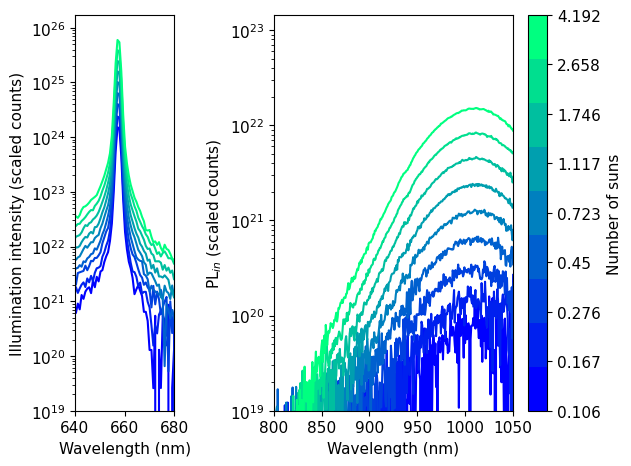

sample: 3_1e-5_Bi


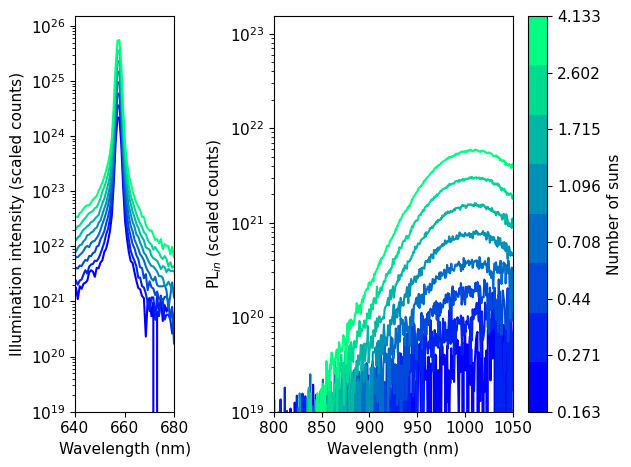

sample: 5_1e-4_Bi


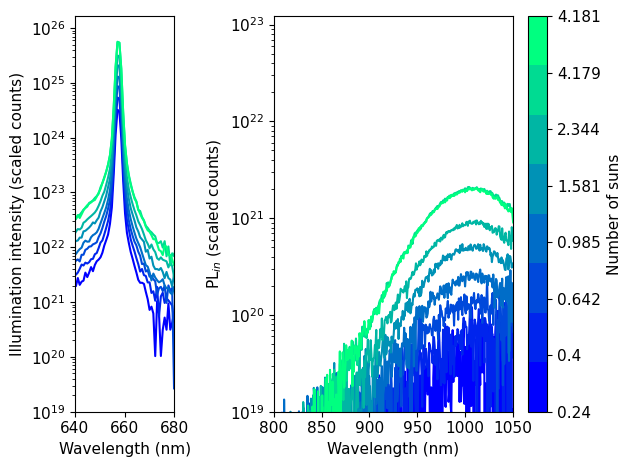

In [6]:
font = {'size'   : 11}
matplotlib.rc('font', **font)

if not os.path.isdir(f"{savepath}/Plots/PL_peaks"):
    os.makedirs(f"{savepath}/Plots/PL_peaks")

for k, measurement_db in enumerate(measurements):
    power = measurement_db["in_empty_subtracted"][0]

    cmap = mpl.cm.get_cmap('winter', len(power))
    c = np.arange(1, len(power) + 1)

    fig = plt.figure()

    ax2 = plt.subplot2grid((3, 3), (0, 0), rowspan=3)
    ax1 = plt.subplot2grid((3, 3), (0, 1), rowspan=3, colspan=3)

    dummie_cax = ax1.scatter(c, c, c=c, cmap=cmap)
    ax1.cla()


    for i in range(len(measurement_db["in_empty_subtracted"][0])): 
        ax1.plot(measurement_db["in_empty_subtracted"][2][i][:,0], 
                measurement_db["in_empty_subtracted"][2][i][:,1], 
                color=cmap(i))

    ax1.set_xlim(PL_range) # feel free to change this
    ax1.set_yscale('log')


    ax1.set_ylim(1e19) # Lower limit, CHANGE THIS AS NEEDED
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('PL$_{in}$ (scaled counts)')

    for i in range(len(measurement_db["in_empty_subtracted"][0])):  
        ax2.plot(measurement_db["empty"][1][i][:,0], 
                measurement_db["empty"][1][i][:,1], 
                color=cmap(i))
    ax2.set_xlim(laser_range) # feel free to change this
    ax2.set_yscale('log')


    ax2.set_ylim(1e19) # Lower limit, CHANGE THIS AS NEEDED
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Illumination intensity (scaled counts)')


    cbar = fig.colorbar(dummie_cax, ticks=c)
    if power_scale == 'suns':
        cbar.ax.set_ylabel("Number of suns")
        cbar.ax.set_yticklabels([round(i, 3) for i in power/power_at_1sun])
    elif power_scale =='power_density':
        cbar.ax.set_ylabel("Power Density (mWcm$^-2$)")
        cbar.ax.set_yticklabels([round(i, 3) for i in power*1e3/(power_meter_scale_factor*spot_size)])

    print('sample:',sample_names[k])

    plt.tight_layout()
    plt.savefig(f"{savepath}/Plots/PL_peaks/{sample_names[k]}_spectra.png")
    plt.show()

## Plot PLQE

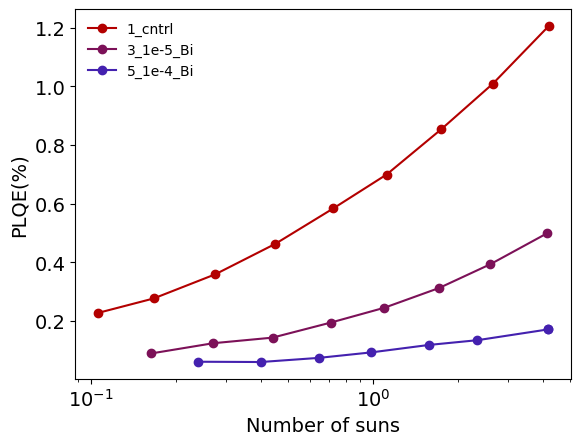

In [7]:
font = {'size'   : 14}
matplotlib.rc('font', **font)
for i, (sample_name, power, PLQE) in enumerate(zip(sample_names, powers, PLQEs)):
    num_suns = power / power_at_1sun

    if power_scale == 'suns':
        plt.plot(power/power_at_1sun, PLQE*100,'-o', c = cpal[i%len(cpal)], label=sample_name)
        plt.xlabel('Number of suns')
    elif power_scale =='power_density':
        plt.plot(power*1e3/(power_meter_scale_factor*spot_size), PLQE*100,'-o', c = cpal[i%len(cpal)], label=sample_name)
        plt.xlabel('Power (mWcm$^{-2}$)')
    plt.xscale('log')
#     plt.yscale('log')

# plt.ylim(0, 100)
plt.ylabel("PLQE(%)")
plt.legend(frameon=False, fontsize=10)


if not os.path.isdir(f"{savepath}/Plots"):
    os.makedirs(f"{savepath}/Plots")
plt.savefig(f"{savepath}/Plots/PLQEs.png")

## Plot QFLS 

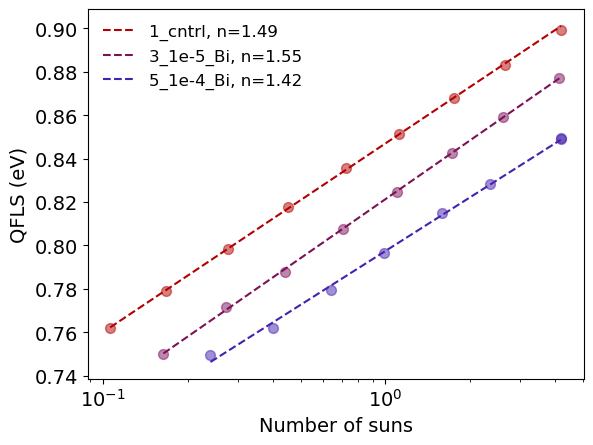

In [8]:
ns = []

for i, (sample_name, power, QFLS) in enumerate(zip(sample_names, powers, QFLSs)):
    num_suns = power/power_at_1sun
    
    plt.scatter(num_suns, QFLS, color=cpal[i%len(cpal)], alpha=0.5, s=50)
    plt.xscale('log')
    plt.xlabel('Number of suns')
    plt.ylabel("QFLS (eV)")

    #### Ideality

    n, (m,c) = ideality_fit(QFLS,num_suns, 0.1, 10)
    ns.append(n)
    x_n = np.array([min(num_suns), max(num_suns)])
    y_n = m*np.log(x_n) +c
    plt.plot(x_n, y_n, color=cpal[i%len(cpal)], label=f'{sample_name}, n={round(n, 2)}', linestyle='--')

    plt.legend(frameon=False, fontsize=12)

## Save ideality
if not os.path.isdir(f"{savepath}/Plots"):
    os.makedirs(f"{savepath}/Plots")
plt.savefig(f"{savepath}/Plots/QFLSs.png")

## Plot Psudo JV

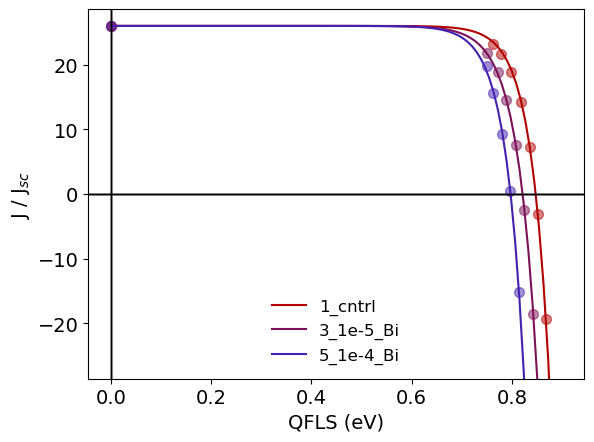

In [9]:
p_voc =[]
p_ff = []
p_pce = []

fig, ax = plt.subplots(dpi=100)
for i, (sample_name, power, QFLS) in enumerate(sorted(zip([i for i in sample_names], powers, QFLSs))):
    # Get current
    num_suns = power / power_at_1sun
    psudo_currents = 1 - num_suns
    # Get Voltage
    QFLS_zeroed, psudo_current_zeroed = ([0],[1])
    for QFLS_i, psudo_current in zip(QFLS, psudo_currents):
        QFLS_zeroed.append(QFLS_i)
        psudo_current_zeroed.append(psudo_current)

    #Fit

    popt, _ = curve_fit(JV_forfit, QFLS, psudo_currents)
    J0 = popt[0]
    n_JV = popt[1]
    

    ax.scatter(QFLS_zeroed, np.array(psudo_current_zeroed)*Psudo_Jsc, color=cpal[i%len(cpal)], alpha=0.5, s=50)
    
    ax.plot(np.linspace(min(QFLS_zeroed), max(QFLS_zeroed),100), 
           JV_forfit(np.linspace(min(QFLS_zeroed), max(QFLS_zeroed),100), J0, n_JV)*Psudo_Jsc,
           color=cpal[i%len(cpal)], label=f'{sample_name}')
    
    # analysis
    
    plt.axvline(0, color='k', linewidth=1)
    plt.axhline(0, color='k', linewidth=1)

    ax.set_xlabel('QFLS (eV)')
    ax.set_ylabel("J / J$_{sc}$")
    plt.ylim(-Psudo_Jsc*1.1,Psudo_Jsc*1.1)
    
    
plt.legend(frameon=False, fontsize=12)


if not os.path.isdir(f"{savepath}/Plots"):
    os.makedirs(f"{savepath}/Plots")
plt.savefig(f"{savepath}/Plots/psudo_JV.png")

plt.show()